In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [2]:
!pwd

/home/qbio1/kangjunseo/tutorials


In [247]:
### functions ###

## calculate header length, but in this file, header was 0
def cal_header_len(code):
    header = 0
    with open(f"alignment/{code}/Aligned.out.sam") as inpfile:
        for line in inpfile:
            if line.startswith('@'): header+=1
            else: continue
    return header
    

## read sam file using chunk
## also this does basic parsing
def read_sam_by_chunk(code, header=0, chunksize=10**5):
    df = pd.DataFrame()
    for cnt, chunk in enumerate(pd.read_csv(f"alignment/{code}/Aligned.out.sam", header=header, sep='\t', chunksize=chunksize)):
        chunk.iloc[:,3] = chunk.iloc[:,3].astype(int)
        chunk = chunk[(chunk.iloc[:,3]>48689480) & (chunk.iloc[:,3]<48689530)]
        if not chunk.empty: df = pd.concat([df,chunk])
        if cnt%10==0: print(cnt, end = ' ')
    return df


## parse dataframe more to analyze
def parse_df(df):
    df.columns = ['read', 'flag', 'chr', 'pos', 'map_qual', 'cigar', 'rnext', 'pnext', 'tlen', 'seq', 'qual',1,2,3,4]
    df_map = df[df['chr']=='chr13'][['pos','cigar','seq']]
    df_map = df_map[~df_map['cigar'].str.contains('S|I')]
    df_map.index = range(225)
    return df_map


## modify sequence using cigar string, add deletion as 'D'
def add_del(df_map):
    add_del_seq = []
    for row in df_map.itertuples():
        if row.cigar.find('D')==-1:
            add_del_seq.append(row.seq)
        else:
            flag = int(row.cigar[:2])
            add_del_seq.append(row.seq[:flag] + 'D' + row.seq[flag:])
        
    add_del_seq_df = pd.Series(add_del_seq)
    df_map = pd.concat([df_map, add_del_seq_df], axis=1)
    df_map = df_map.drop(labels='seq',axis=1)
    df_map.columns = ['pos', 'cigar', 'seq']
    return df_map
    
    
## calculate shannon entropy
def shannon(seq, base):
    p = seq.count(base)/len(seq) 
    return 0 if (p==0 or p==1) else (-p*np.log2(p) -(1-p)*np.log2(1-p))

In [250]:
df_map = add_del(parse_df(read_sam_by_chunk("CLIP_35L33G")))
df_map

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 

,pos,cigar,seq
0,48689514,14M1D64M,TCGTATAGTTAACTDCTTGTGGGCAAAATCTCTGCCCTAAAACTAT...
1,48689491,37M1D23M,AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTDCTTGTGGG...
2,48689489,39M1D23M,ATAAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTDCTTGTG...
3,48689502,30M,AAAGGCAGCAGGTCGTATAGTTAACTCCTT
4,48689502,30M,AAAGGCAGCAGGTCGTATAGTTAACTCGTT
...,...,...,...
220,48689514,14M1D64M,TCGTATAGTTAACTDCTTGTGGGCAAAATCTCTGCCCTAAAACTAT...
221,48689515,78M,CGTATAGTTAACTCCTTGTGGGCAAAATCTCTGCCCTAAAACTATG...
222,48689490,62M,TAAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCTTTGTGG...
223,48689491,37M1D23M,AAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTDCTTGTGGG...


In [237]:
pos_map = defaultdict(str)
for row in df_map.itertuples():
    for idx, base in enumerate(row.seq):
        pos_map[idx+row.pos]+=base

In [275]:
ref_seq = "TAAGGCCCTAAGAAAGGCAGCAGGTCGTATAGTTAACTCCTTGTGGGCAAAATCTCTGCCC"
x_axis = range(48689490,48689551)
y_axis = []
for idx, pos in enumerate(x_axis):
    y_axis.append(shannon(pos_map[pos],ref_seq[idx]))

Text(48689529, 1.1224491812352424, '0.9924')

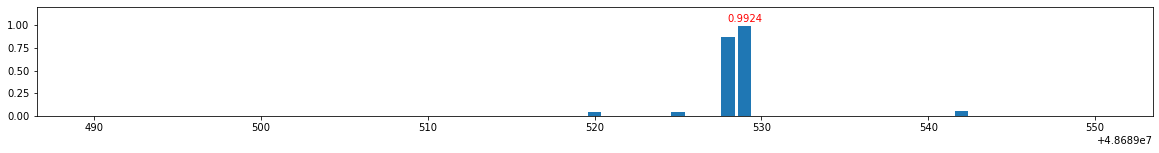

In [276]:
dic = { y:x for x, y in zip(x_axis, y_axis) }
plt.figure(figsize=(20,2))
plt.bar(x_axis,y_axis)
plt.ylim(0,1.2)
plt.text(dic[max(y_axis)],0.13+max(y_axis),
         str(round(max(y_axis),4)),
         color='r',
         horizontalalignment='center',
         verticalalignment='top')